**Download von GWR Daten**

Import der notwendigen Packages und Definition der Variablen
Als Pfad wird der aktuelle Pfad gesucht.

'kt' beschreibt den Kanton als Kürzel mit Kleinbuchstaben.

In [1]:
import os, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from urllib import request
from datetime import date
import shutil
import glob
import zipfile
import re

kt, parent_dir, today = 'nw', os.path.abspath('./.'), date.today()
print("Today's date:", today)

C:\Users\MA1178490\AppData\Local\Temp\ipykernel_19000\923284146.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import os, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt


Today's date: 2023-10-23


Download und Extraktion des ZIP-files

In [3]:
# GWR
        # Download und Save - Define the remote file to retrieve
gwr_url = f'https://public.madd.bfs.admin.ch/{kt}.zip'
        # Define the local filename to save data
gwr_path = os.path.join(parent_dir, f'{today}_{kt}_gwr.zip')
# local_file = 'local_copy.txt'
        # Download remote and save locally
request.urlretrieve(gwr_url, gwr_path)
# %%
with zipfile.ZipFile(gwr_path,'r') as gwr_source:
    # Erhalte eine Liste mit alle Dateien die in dem ZIP Vorhanden sind
    gwr_files = gwr_source.namelist()
    for i in range(len(gwr_files)):
        if '.csv' in gwr_files[i]:
            gwr_csv = gwr_files[i]
            print(gwr_csv)
        # Ein Bestimmte Datei aus dem ZIP Lesen und in einen String Convertieren
            gwr_source.extract(gwr_csv, f'{parent_dir}/GWR/{today}_{kt}_gwr/')

eingang_entree_entrata.csv
gebaeude_batiment_edificio.csv
kodes_codes_codici.csv
wohnung_logement_abitazione.csv


Umschreiben der Datenbeschreibungen

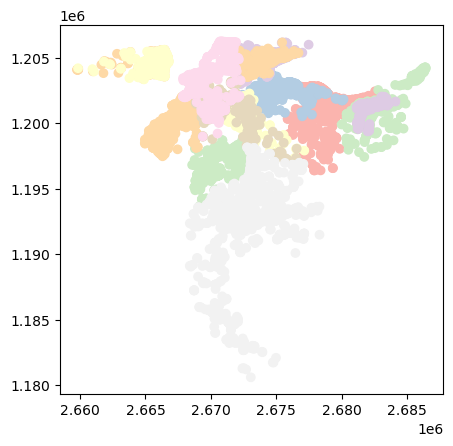

In [4]:
    #GWR - Gebäudedaten aufbereiten
GWR_Kt_df = pd.read_csv(f'{parent_dir}/GWR/{today}_{kt}_gwr/gebaeude_batiment_edificio.csv', sep='\t') #, index_col=0 womöglich muss unter Windows ein vor den Ordnerpfad noch ein '/'
GWR_Kt_df = GWR_Kt_df.drop(columns=["LGBKR", "LPARZSX","GGDENR", "GSCHUTZR", "GKSCE", "LTYP", "GEBNR", "GBAUM", "GBAUP", "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT", "GWAERSCEH2",  "GWAERDATH2", "GWAERZW1", "GWAERZW2", "GWAERZH2"])
GWR_Kt_df = GWR_Kt_df[GWR_Kt_df.GSTAT.isin([1001, 1002, 1003, 1004])] #Löschen von abgerissenen, nicht realisierten und nicht nutzbaren Gebäuden
    # Einlesen des Kodierungs csv
GWR_Cod_df = pd.read_csv(f'{parent_dir}/GWR/{today}_{kt}_gwr/kodes_codes_codici.csv', sep='\t', index_col=0) #womöglich muss unter Windows ein vor den Ordnerpfad noch ein '/'
    # Erstellen der GSTAT-Labels und Merge der Labels an GWR
GWR_GSTAT_df = GWR_Cod_df[GWR_Cod_df.CMERKM == 'GSTAT']
GWR_GSTAT_df = GWR_GSTAT_df.drop(columns=["CMERKM", "CODTXTLD", "CODTXTLF", "CODTXTKF", "CODTXTLI", "CODTXTKI", "CEXPDAT"]) # "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT"])
GWR_Kt_df = GWR_Kt_df.merge(right=GWR_GSTAT_df, right_index=True, left_on='GSTAT', how='left')
GWR_Kt_df.rename(columns={'CODTXTKD':'Geb_Status'}, inplace=True)
    # Erstellen der GKAT-Labels und Merge der Labels an GWR
GWR_GKAT_df = GWR_Cod_df[GWR_Cod_df.CMERKM == 'GKAT']
GWR_GKAT_df = GWR_GKAT_df.drop(columns=["CMERKM", "CODTXTLD", "CODTXTLF", "CODTXTKF", "CODTXTLI", "CODTXTKI", "CEXPDAT"]) # "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT"])
GWR_Kt_df  = GWR_Kt_df.merge(right=GWR_GKAT_df, right_index=True, left_on='GKAT', how='left')
GWR_Kt_df.rename(columns={'CODTXTKD':'Geb_Kategorie'}, inplace=True)
    # Erstellen der GKLAS-Labels und Merge der Labels an GWR
GWR_GKLAS_df = GWR_Cod_df[GWR_Cod_df.CMERKM == 'GKLAS']
GWR_GKLAS_df = GWR_GKLAS_df.drop(columns=["CMERKM", "CODTXTLD", "CODTXTLF", "CODTXTKF", "CODTXTLI", "CODTXTKI", "CEXPDAT"]) # "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT"])
GWR_Kt_df  = GWR_Kt_df.merge(right=GWR_GKLAS_df, right_index=True, left_on='GKLAS', how='left')
GWR_Kt_df.rename(columns={'CODTXTKD':'Geb_Klasse'}, inplace=True)
    # Erstellen der GWAERZH1-Labels und Merge der Labels an GWR
GWR_GWAERZH1_df = GWR_Cod_df[GWR_Cod_df.CMERKM == 'GWAERZH1']
GWR_GWAERZH1_df = GWR_GWAERZH1_df.drop(columns=["CMERKM", "CODTXTLD", "CODTXTLF", "CODTXTKF", "CODTXTLI", "CODTXTKI", "CEXPDAT"]) # "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT"])
GWR_Kt_df  = GWR_Kt_df.merge(right=GWR_GWAERZH1_df, right_index=True, left_on='GWAERZH1', how='left')
GWR_Kt_df.rename(columns={'CODTXTKD':'Geb_Heizung1'}, inplace=True)
    # Erstellen der GENH1-Labels und Merge der Labels an GWR
GWR_GENH1_df = GWR_Cod_df[GWR_Cod_df.CMERKM == 'GENH1']
GWR_GENH1_df = GWR_GENH1_df.drop(columns=["CMERKM", "CODTXTLD", "CODTXTLF", "CODTXTKF", "CODTXTLI", "CODTXTKI", "CEXPDAT"]) # "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT"])
GWR_Kt_df  = GWR_Kt_df.merge(right=GWR_GENH1_df, right_index=True, left_on='GENH1', how='left')
GWR_Kt_df.rename(columns={'CODTXTKD':'Geb_Energiequelle1'}, inplace=True)
    # überflüssige Spalten löschen
GWR_Kt_df = GWR_Kt_df.drop(columns=["GSTAT", "GKAT", "GKLAS", "GWAERZH1"]) #, "LGBKR", "LPARZSX", "LTYP", "GEBNR", "GBAUM", "GBAUP", "GABBJ", "GVOLNORM", "GVOLSCE", "GAZZI","GENW1" ,"GWAERSCEW1", "GWAERDATW1", "GENW2" ,"GWAERSCEW2", "GWAERDATW2", "GEXPDAT"])
GWR_Kt_df.rename(columns={'GASTW':'AnzGeschosse', 'GANZWHG':'AnzWohnung', }, inplace=True)
    # GWR als GeoDataFrame speichern
GWR_Kt_gdf = gpd.GeoDataFrame(GWR_Kt_df, geometry=gpd.points_from_xy(GWR_Kt_df.GKODE, GWR_Kt_df.GKODN), crs="EPSG:2056")
GWR_Kt_gdf = GWR_Kt_gdf.drop(columns={'GWAERDATH1','EGRID', 'GKODE', 'GKODN', 'GENH1', 'GWAERSCEH1', 'GENH2'})
GWR_Kt_gdf.to_file(f'{parent_dir}/GWR/{today}_{kt}_gwr/{today}_{kt}_gwr.gpkg', layer = 'GWR', driver="GPKG", encoding='utf-8')
GWR_Kt_gdf.plot(cmap='Pastel1')
plt.show()